In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

# Define function to approximate value of x(t), solution of dx/dt
def x_approx(coeffs, t):
    '''
    Inputs:
    (coeffs): list of coefficients used in the polynomial approximation from t0 to tend
    (t): time point to evaluate x(t) approximation
    '''
    x_approx = coeffs[0] + coeffs[1]*t + coeffs[2]*t**2 + coeffs[3]*t**3 + coeffs[4]*t**4
    return x_approx

# Use Pyomo to solve for new coefficients for x(t) approximation based on x0 guess
def get_coeffs(x0):
    '''
    Inputs: x0, 
    Outputs: new coefficients for x(t) approximation (c0, c1, c2, c3, c4)

    Process:
    1. Define Pyomo variables for coefficients
    2. Define Pyomo constraints for equations to solve using collocation points
    3. Solve for coefficients
    '''
    # Create Pyomo model
    m = pyo.ConcreteModel()

    # Define the approximation coefficients as Pyomo variables
    m.c0 = pyo.Var()
    m.c1 = pyo.Var()
    m.c2 = pyo.Var()
    m.c3 = pyo.Var()
    m.c4 = pyo.Var()

    # Define the system of equations as Pyomo constraints
    def eq1(m):
        return m.c0 == x0
    def eq2(m):
        return -(m.c0)**3 == m.c1
    def eq3(m):
        return -(m.c0 + m.c1/3 + m.c2/9 + m.c3/27 + m.c4/81)**3 == m.c1 + m.c2*2/3 + m.c3*3/9 + m.c4*4/27
    def eq4(m):
        return -(m.c0 + m.c1*2/3 + m.c2*4/9 + m.c3*8/27 + m.c4*16/81)**3 == m.c1 + m.c2*4/3 + m.c3*3*4/9 + m.c4*4*8/27
    def eq5(m):
        return -(m.c0 + m.c1 + m.c2 + m.c3 + m.c4)**3 == m.c1 + m.c2*2 + m.c3*3 + m.c4*4
    
    m.eq1 = pyo.Constraint(rule=eq1)
    m.eq2 = pyo.Constraint(rule=eq2)
    m.eq3 = pyo.Constraint(rule=eq3)
    m.eq4 = pyo.Constraint(rule=eq4)
    m.eq5 = pyo.Constraint(rule=eq5)

    # Solve for Pyomo variables/coefficients
    # Dummy objective
    m.obj = pyo.Objective(expr=0, sense=pyo.minimize)
    solver = pyo.SolverFactory('ipopt')
    solver.solve(m)

    c0 = pyo.value(m.c0)
    c1 = pyo.value(m.c1)
    c2 = pyo.value(m.c2)
    c3 = pyo.value(m.c3)
    c4 = pyo.value(m.c4)

    # print(f"c0 = {c0}")
    # print(f"c1 = {c1}")
    # print(f"c2 = {c2}")
    # print(f"c3 = {c3}")
    # print(f"c4 = {c4}")

    c_list = [c0, c1, c2, c3, c4]

    return c_list




Use the functions to solve for x0

In [2]:
# Define range of time values
t0, tend = 0, 1
# Target x value at tend
xd = 0.5

# Initialize list to store x0 values and pick initial guess
x0 = []
x0.append(1)

# Initialize array to store coefficients
coeff_guesses = []

# Add proportionality constant for control, tolerance
K = 1
tol = 0.0001
err = []
err.append(10)

# Add max iterations and iteration counter
max_iters = 100000
iters = 0

print(f'Target x(tend) = x({tend}): {xd}')
print("Initial x0 guess: ", x0[0])
print(f'Prop. constant: {K}')


while abs(err[-1]) > tol:
    # Use x0 guess to solve for approximation coefficients
    c_guess = get_coeffs(x0[-1])
    # Append the new list to the list of coefficient guesses
    coeff_guesses.append(c_guess)

    # Solve for the x value at tend using the approximation
    x_tend = x_approx(coeff_guesses[-1], x0[-1])

    # Error > 0 if x(tend) < xd, want to increase x0
    err.append(xd - x_tend)
    iters += 1
    if iters >= max_iters:
        print(f'Max iterations reached! Error: {err[-1]}')
        print(f'Final x0: {x0[-1]}')
        print(err)
        print(x0)
        break
    if abs(err[-1]) < tol:
        print(f'\nSolution obtained! x0 = {x0[-1]}')
        print(f'x(tend) = {x_tend}')
        print(f'Final error value: {err[-1]}')
        print(f'Final coefficients: {coeff_guesses[-1]}')
        print(f'Iterations used: {iters}')
        print(f'\nCoefficient list: {coeff_guesses}')
        break
    # Use prop. constant and last error for next x0 value
    x0.append(x0[-1] + K*err[-1])

    (xd - x_tend)


Target x(tend) = x(1): 0.5
Initial x0 guess:  1
Prop. constant: 1

Solution obtained! x0 = 0.5971377713067454
x(tend) = 0.5000539027124361
Final error value: -5.390271243610467e-05
Final coefficients: [0.5971377713067454, -0.21292351579846341, 0.10982760518255946, -0.0499294810681177, 0.012036290237473456]
Iterations used: 17

Coefficient list: [[1.0, -1.0, 1.2233811321796568, -0.9590734469041239, 0.3102073339992943], [0.9254849807251728, -0.7926986627104915, 0.8645599682861063, -0.6367032486315758, 0.19948742586753057], [0.8514793973027976, -0.6173371778634148, 0.5910199255224272, -0.40396722946801383, 0.1217796305896002], [0.7825208380435501, -0.4791679194372605, 0.39935442398937365, -0.2510540064707248, 0.07242059067586215], [0.7235609306142783, -0.37881339373470735, 0.27615232685875524, -0.1594464186039221, 0.04393981562327987], [0.6778744404325977, -0.31149263089190216, 0.2024231830191112, -0.10828423990794087, 0.028617417379520175], [0.6458237478404253, -0.26936553765947796, 0.16

Plot to view the solution

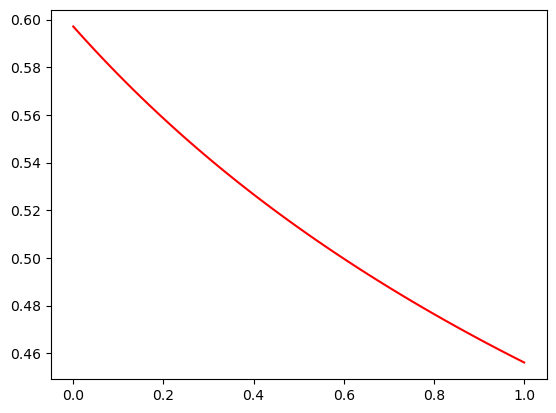

In [3]:
# Use final coefficients in approximate equation for x(t)

t_plot = np.linspace(t0,tend,100)
x_plot = x_approx(coeff_guesses[-1], t_plot)

plt.figure()
plt.plot(t_plot, x_plot, color='red')
plt.show()